In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import image
from pathlib import Path
from tensorflow.keras import models, layers, Model, Input

from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, UpSampling2D, MaxPooling2D, concatenate

from PIL import Image
from numpy import asarray

In [2]:
isic_input_path = './../../../dataset/ISIC2018_Task1-2_Training_Input_x2/*.jpg'

isic_groundTruth_path = './../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2/*.png'

In [3]:
isic_input = sorted(glob.glob(isic_input_path))
isic_groundTruth = sorted(glob.glob(isic_groundTruth_path))

DATASET_SIZE = len(isic_input)
BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 4
# print(len(isic_groundTruth))

In [4]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

# print(train_size, val_size, test_size)

In [5]:
full_ds = tf.data.Dataset.from_tensor_slices((isic_input, isic_groundTruth))
full_ds = full_ds.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

train_ds = full_ds.take(train_size)

# skip the dataset for train
test_ds = full_ds.skip(train_size)

val_ds = full_ds.skip(val_size)
test_ds = full_ds.take(test_size)

In [6]:
for image, label in train_ds.take(5):
    print('Image file:', image.numpy())
    print('Label:', label.numpy())

Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0013498.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0013498_segmentation.png'
Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0010473.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0010473_segmentation.png'
Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0014926.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0014926_segmentation.png'
Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0014457.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0014457_segmentation.png'
Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0012852.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0012852_segmentation.png'


In [7]:
# def get_palette(a_input):
#     sample = cv2.cvtColor(cv2.imread((a_input)), cv2.COLOR_RGB2RGBA)
#     print(sample.shape)
#     sample = cv2.resize(sample, (256,256))
#     # print(test.shape)
#     # print(test)

#     my_list= []
#     for i in range(sample.shape[0]):
#         for j in range(sample.shape[1]):
#             my_list.append(sample[i,j,:].tolist())
    
#     palette = sort_and_deduplicate(my_list)
#     # print(palette)
#     return palette

# def uniq(lst):
#     last = object()
#     for item in lst:
#         if item == last:
#             continue
#         yield item
#         last = item

# def sort_and_deduplicate(l):
#     return list(uniq(sorted(l, reverse=True)))


# palette = get_palette(isic_groundTruth[0])
# palette2 = get_palette(isic_groundTruth[1])
# palette = [[255, 255, 255, 255], [0, 0, 0, 255]]
palette = [255, 0]
print(len(palette))

2


[  0. 255.]
./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\ISIC_0000000_segmentation.png


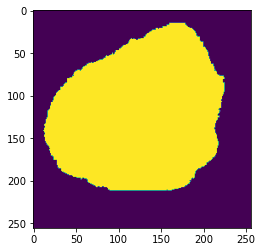

In [8]:
# sample2 = cv2.cvtColor(cv2.imread((isic_groundTruth[0])), cv2.COLOR_RGB2RGBA)
sample2 = tf.io.read_file(isic_groundTruth[0])
sample2 = tf.image.decode_png(sample2, channels=1)

sample2 =  tf.image.resize(sample2, [IMG_WIDTH, IMG_HEIGHT])
# gray_image = tf.squeeze(sample2) # shape (127,127,1) -> shape (127,127)
select_op = tf.where(sample2>127, 255*tf.ones_like(sample2), tf.zeros_like(sample2))
select_op = tf.reshape(select_op, (256, 256, 1))
print(np.unique(select_op))
print(isic_groundTruth[0])
plt.imshow(select_op)

# sample2 =  tf.image.resize(sample2, [IMG_WIDTH, IMG_HEIGHT])
# print(sample2.shape)

# # for i in sample2:
# #     for j in i:
# #         print(j)
# unique = np.unique(sample2)
# print(unique)

In [9]:
def decode_img(image):
    image = tf.image.decode_jpeg(image, channels=0)
    # resize the image 256*256 
    image =  tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    # Standardise values to be in the [0, 1] range.
    image = tf.cast(image, tf.float32) / 255.0
    
    return image
    
def decode_label(label):
#     label = tf.image.decode_png(label)
#     label = label == [255, 0]
#     label = tf.reshape(label, (256, 256, 2))
#     print(label.shape)
    
#     return label

    label = tf.image.decode_png(label, channels=1)
    # Resize the image to the desired size.
    label =  tf.image.resize(label, [IMG_WIDTH, IMG_HEIGHT])
    
    label = tf.where(label > 127, 255*tf.ones_like(label), tf.zeros_like(label))
    label = tf.reshape(label, (IMG_WIDTH, IMG_HEIGHT, 1))
    label = tf.cast(label, tf.float32) / 255.0
    print("before one hot:", label.shape)
    return label
    
#     one_hot_map = []

#     for clr in palette:
#         class_map = tf.equal(label, clr)
#         class_map = tf.reduce_all(class_map,axis=-1)
#         one_hot_map.append(class_map)
    
#     one_hot_map = tf.stack(one_hot_map, axis=-1)
#     one_hot_map = tf.cast(one_hot_map, tf.uint8)
#     print("after one hot:", one_hot_map.shape)
    
#     return one_hot_map

    
def process_data(image, label):
    image = tf.io.read_file(image)
    image = decode_img(image)
    
    label = tf.io.read_file(label)
    label = decode_label(label)
    
    return image, label   

In [10]:
# Use Dataset.map to apply this transformation.
processed_train_ds = train_ds.map(process_data)
processed_val_ds = val_ds.map(process_data)

processed_test_ds = test_ds.map(process_data)

before one hot: (256, 256, 1)
before one hot: (256, 256, 1)
before one hot: (256, 256, 1)


Image shape: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0013498.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0013498_segmentation.png'

Image shape: (256, 256, 3)
Label: (256, 256, 1)
tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(256, 256, 1), dtype=float32)


(-0.5, 255.5, 255.5, -0.5)

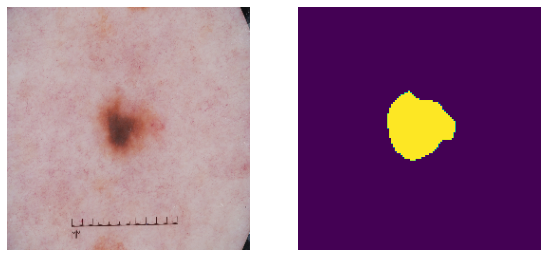

In [11]:
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy())
    print('Label:', label.numpy())
print()

output_size = 0
for image, label in processed_train_ds.take(1):
    output_size = label.numpy().shape[2]
    print('Image shape:', image.numpy().shape)
    print('Label:', label.numpy().shape)
plt.figure(figsize=(20, 10))

# print(output_size)

print(label)
plt.subplot(1, 4, 1)
plt.imshow(image.numpy())
plt.axis('off')

plt.subplot(1, 4, 2)
# plt.imshow(tf.argmax(label.numpy(), axis=2))
plt.imshow(label.numpy())
plt.axis('off')

In [12]:
from model import *

model = unet(output_size)
if (output_size > 2):
    print("Loss Function: categorical_crossentropy")
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
else:
    print("Loss Function: binary_crossentropy")
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

print()
model.summary()

Loss Function: binary_crossentropy

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
__________________________________________________________

In [13]:
def dice_coef(img, img2):
    if img.shape != img2.shape:
        raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
    else:
        img = img.numpy().astype(np.bool)
        img2 = img2.astype(np.bool)
        intersection = np.logical_and(img, img2)
        value = (2. * intersection.sum())  / (img.sum() + img2.sum())
    return value 

# preds_test[0].astype(np.bool)
def display(image, ground_truth, prediction, num):
    plt.figure(figsize=(20, 20))
    colors = ['black', 'green', 'red']
    for i in range(num):
        plt.subplot(4, 3, 3*i+1)
        plt.imshow(image[i])
        title = plt.title('The actual image')
        plt.setp(title, color=colors[0])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+2)
#         plt.imshow(tf.argmax(ground_truth[i], axis=-1))
        plt.imshow(ground_truth[i])
        title = plt.title('Ground truth image segmentation')
        plt.setp(title, color=colors[1])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+3)
#         plt.imshow(tf.argmax(prediction[i], axis=-1))
        plt.imshow(prediction[i])
        title = plt.title('Prediction image segmentation')
        plt.setp(title, color=colors[2])
        plt.axis('off')

        print("DICE SIMILARITY FOR INPUT {}: {}".format(i, dice_coef(ground_truth[i], prediction[i])))
    plt.show()
    
# display(label_test_batch, preds_test)

def show_predictions(processed_test_ds, num=3):
    image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(3)))
    prediction = model.predict(image_test_batch)
    display(image_test_batch, label_test_batch, prediction, num)

from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(processed_test_ds)

DICE SIMILARITY FOR INPUT 0: 0.10425224182817472
DICE SIMILARITY FOR INPUT 1: 0.5772220051235292
DICE SIMILARITY FOR INPUT 2: 0.2976778014442309


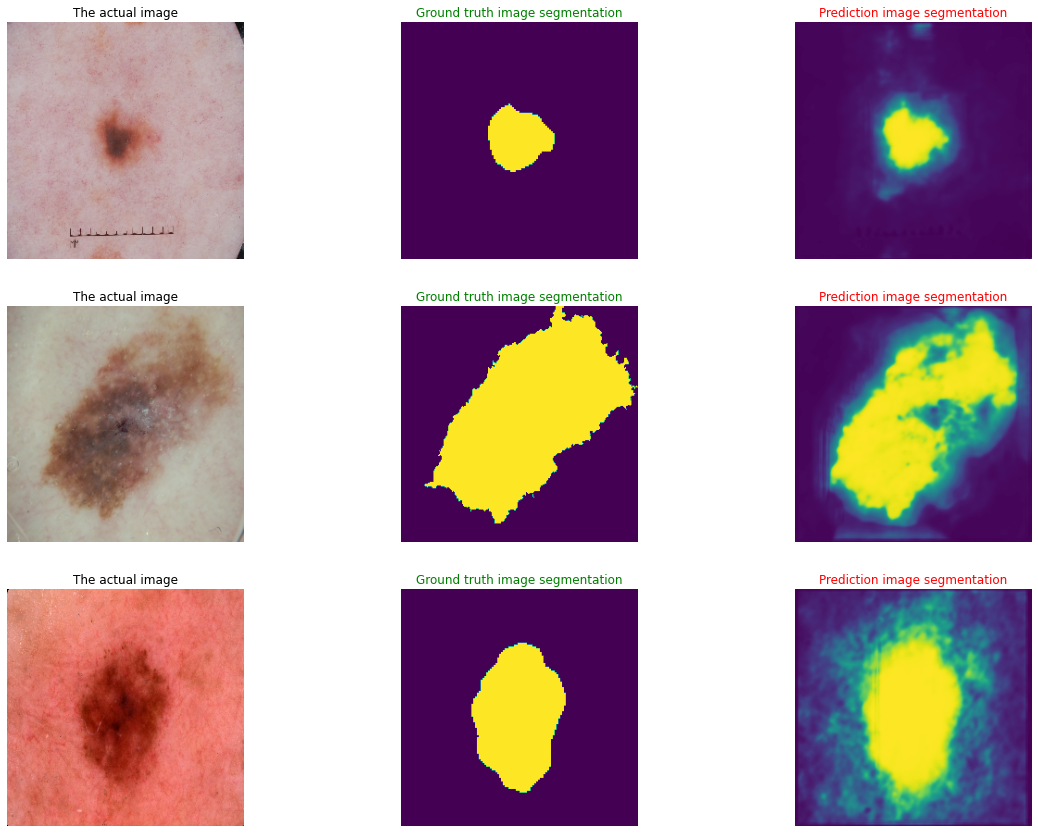

227/227 [==============================] - 163s 719ms/step - loss: 0.2383 - accuracy: 0.9089 - val_loss: 0.2145 - val_accuracy: 0.9193


In [14]:
history = model.fit(processed_train_ds.batch(BATCH_SIZE), 
                    validation_data=processed_val_ds.batch(BATCH_SIZE), 
                    epochs=10, callbacks=[DisplayCallback()])

In [15]:
test_loss, test_acc = model.evaluate(processed_test_ds.batch(BATCH_SIZE), verbose=2)

49/49 - 15s - loss: 0.2207 - accuracy: 0.9159


(256, 256, 1)
0.9623101952277657


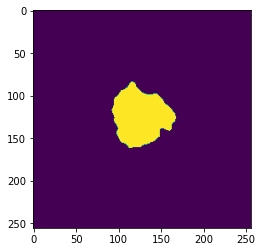

In [29]:
image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(3)))
prediction = model.predict(image_test_batch)
plt.imshow(prediction[0])
print(prediction[0].shape)
test = tf.where(prediction[0] > 0.5, tf.ones_like(prediction[0]), tf.zeros_like(prediction[0]))
plt.imshow(test)

print(dice_coef(label_test_batch[0], test.numpy()))

In [17]:
# show_predictions(processed_test_ds)

In [ ]:
################# HERE I USED SIGMOID INSTEAD OF SOFTMAX, INIT KERNEL IS 32